<h1>ENRON EMAIL DATASET</h1><br>
The Enron email dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse

![alt text](https://upload.wikimedia.org/wikipedia/commons/3/3f/Logo_de_Enron.svg)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
# Start by importing all the things we'll need.
%matplotlib inline
import unicodedata
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import shutil
import tensorflow as tf

import pandas as pd
import numpy as np
import string, os 
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K
from IPython.display import Image

__this dataset is in compressed format we have to seperate the different category by below code__
https://towardsdatascience.com/how-i-used-machine-learning-to-classify-emails-and-turn-them-into-insights-efed37c1e66

In [0]:
data = pd.read_csv('emails.csv')

In [9]:
data.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [10]:
print(data.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [11]:
headers = [header for header in data.columns]

headers

['file', 'message']

In [0]:
#https://docs.python.org/3/library/email.parser.html

In [13]:
import email
#this function is used to create ditionary which is used to make data frame
def insert_value(dictionary, key, value):
    if key in dictionary:
        values = dictionary.get(key)
        values.append(value)
        dictionary[key] = values
    else:
        dictionary[key] = [value]
    return dictionary

def get_headers(df, header_names):
    headers = {}
    messages = df["message"]
    for message in messages:
      #taking single row and taking full message part
        e = email.message_from_string(message)
        for item in header_names:
            header = e.get(item)
            #get the information and store the information in dictionary
            insert_value(dictionary = headers, key = item, value = header) 
    print("Successfully retrieved header information!")
    return headers
header_names = ["Date", "Subject", "X-Folder", "X-From", "X-To","From","To","X-Origin"]    
headers = get_headers(data, header_names)

Successfully retrieved header information!


In [14]:
def get_messages(df):
    messages = []
    for item in df["message"]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get payload is used to extract message body  
        message_body = e.get_payload()
        message_body = message_body.lower()
        messages.append(message_body)
    print("Successfully retrieved message body from e-mails!")
    return messages
msg_body = get_messages(data)
data["Message-Body"] = msg_body

Successfully retrieved message body from e-mails!


In [15]:
def add_name(df, column, labels):
    new_data = {}
    for item in df[column]: 
        tokens = item.split('/')
        for i in range(0, len(labels)):
            value = tokens[i]
            key = labels[i]
            new_data = insert_value(new_data, key, value)        
    for key, value in new_data.items():
        df[key] = pd.Series(value)
    print("Successfully added new column!")
    return df
data = add_name(df = data, column = "file", labels = ["employee"])


Successfully added new column!


In [16]:
def add_headers(df, header_list):
    for label in header_list:
        df_new = pd.DataFrame(headers[label], columns = [label])
        if label not in df.columns:
            df = pd.concat([df, df_new], axis = 1)
    return df
remaining_headers = ["Date", "Subject", "X-To", "X-From", "X-Folder","From","To","X-Origin"]
data = add_headers(df = data, header_list = remaining_headers)
data.drop(columns=['message'],axis=1 , inplace= True)
data.head()

,file,Message-Body,employee,Date,Subject,X-To,X-From,X-Folder,From,To,X-Origin
0,allen-p/_sent_mail/1.,here is our forecast\n\n,allen-p,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,Tim Belden <Tim Belden/Enron@EnronXGate>,Phillip K Allen,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",phillip.allen@enron.com,tim.belden@enron.com,Allen-P
1,allen-p/_sent_mail/10.,traveling to have a business meeting takes the...,allen-p,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,John J Lavorato <John J Lavorato/ENRON@enronXg...,Phillip K Allen,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",phillip.allen@enron.com,john.lavorato@enron.com,Allen-P
2,allen-p/_sent_mail/100.,test successful. way to go!!!,allen-p,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,Leah Van Arsdall,Phillip K Allen,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,phillip.allen@enron.com,leah.arsdall@enron.com,Allen-P
3,allen-p/_sent_mail/1000.,"randy,\n\n can you send me a schedule of the s...",allen-p,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",,Randall L Gay,Phillip K Allen,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,phillip.allen@enron.com,randall.gay@enron.com,Allen-P
4,allen-p/_sent_mail/1001.,let's shoot for tuesday at 11:45.,allen-p,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,Greg Piper,Phillip K Allen,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,phillip.allen@enron.com,greg.piper@enron.com,Allen-P


<h1>EXPLORATORY DAtA ANALYSIS</h1>

Text(0, 0.5, 'N emails')

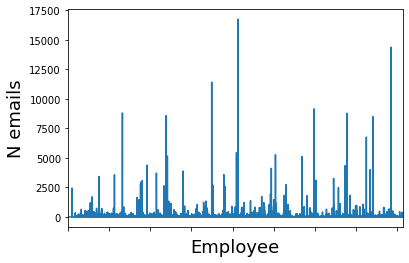

In [17]:
ax = data.groupby(data['From'])['Message-Body'].count()
ax=ax.plot()
ax.set_xticklabels([])
ax.set_xlabel('Employee', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

__THe maximum amount of mail sent is nearly 17000__

In [0]:
#Creating from_user list
userList = []
userList = data['X-Origin'].unique()

In [0]:
#Number of emails sent by each users

count = []
counter = 0 
for l in userList:
    for user in data['X-Origin']:
        if user == l:
            counter += 1
    count.append(counter)
    counter = 0

In [0]:
import matplotlib.pyplot as plt

[(26995, 'Kaminski-V'), (26323, 'DASOVICH-J'), (23621, 'KEAN-S'), (22414, 'MANN-K'), (18598, 'JONES-T'), (16158, 'SHACKLETON-S'), (13875, 'Taylor-M'), (11677, 'Farmer-D'), (10827, 'SYMES-K'), (9619, 'Germany-C'), (9056, 'Beck-S'), (8913, 'NEMEC-G'), (7495, 'Rogers-B'), (7329, 'Sanders-R'), (7158, 'Bass-E'), (6228, 'SCOTT-S'), (6054, 'GUZMAN-M'), (4663, 'FOSSUM-D'), (4621, 'Campbell-L'), (4614, 'Arnold-J')]


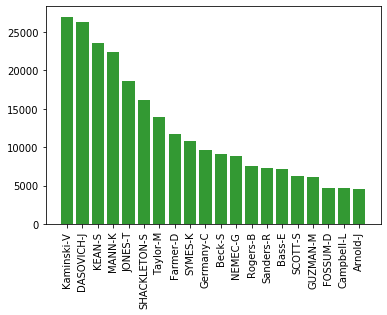

'The histogram shows users vs no. of emails they sent'

In [21]:
'''Let us take a look at how many email were sent by each user. 
This plot may indicate erratic email usage. 
We plot top 20 users who sent the highest number of emails.'''

new_list = sorted(list(zip(count, userList)), reverse = True)[:20] ##merge both lists and sort top 20, 
print(new_list)
num, mailer = zip(*new_list) ## separate lists previously merged and use them for plotting
mail = range(len(new_list))
plt.bar(mail, num, align = 'center', color ='green', alpha=0.8)
plt.xticks(mail, mailer, rotation='vertical')
plt.show()

'''The histogram shows users vs no. of emails they sent'''

__ABOVE HISTOGRAM IS USED FOR CHECKING WHICH USER SEND the MOST MAILS__

In [0]:
dfnew = data.head(n=200)

In [0]:
# Network analysis
import networkx as nx

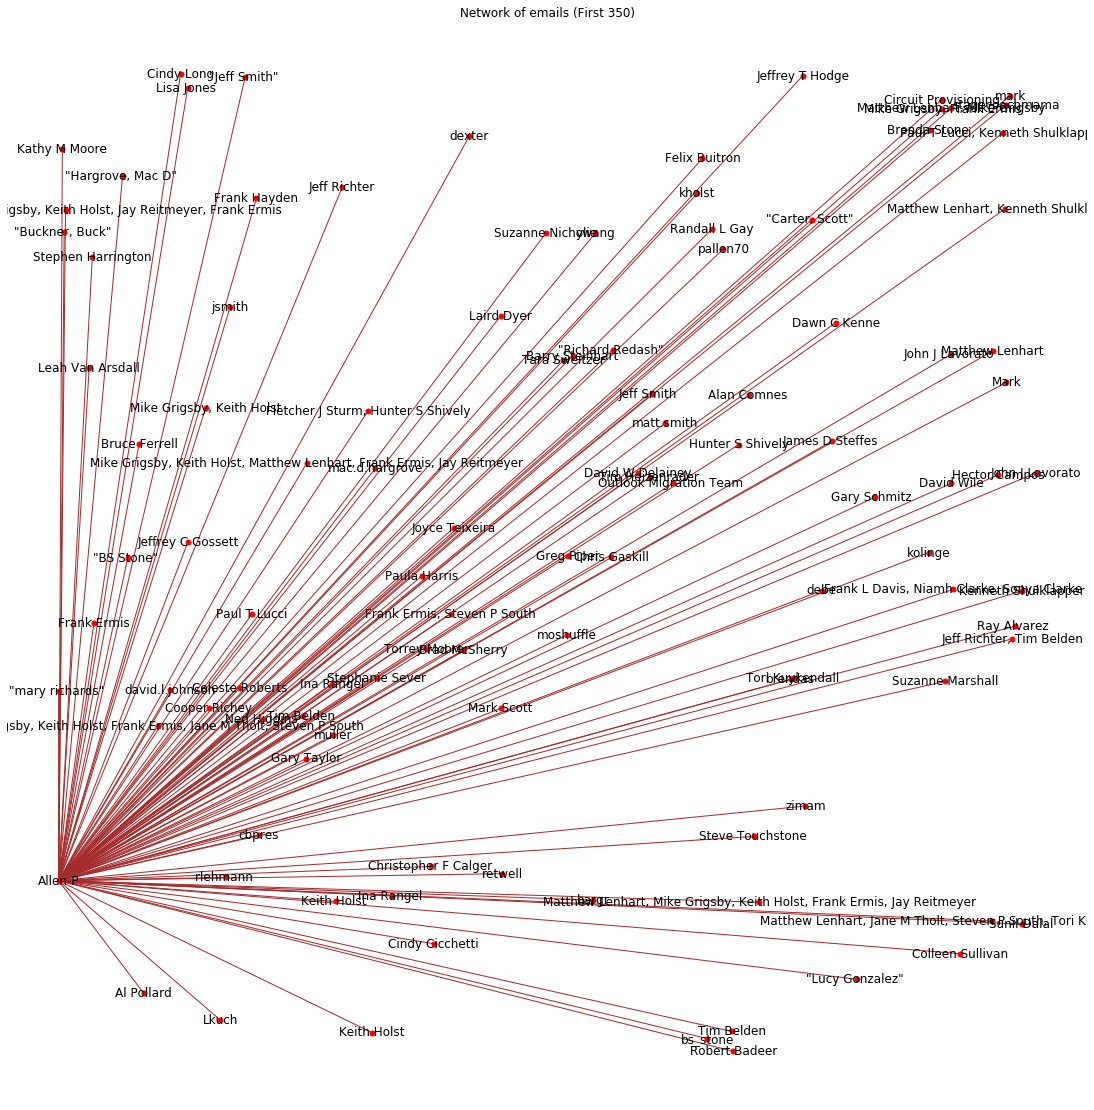

In [24]:
toUSER = []
for user in dfnew['X-To']:
    user = user.split('<')[0]
    user = user.split('@')[0]
    toUSER.append(user)
newlister = list(zip(dfnew['X-Origin'],toUSER))
datanewf = pd.DataFrame(newlister)
datanewf.columns = ['fromuser', 'touser']
G = nx.from_pandas_edgelist(datanewf, 'fromuser', 'touser')
plt.figure(figsize=(15,15))
pos = nx.draw_random(G, node_size = 25, node_color = 'red', edge_color = 'brown', with_labels = True)
plt.title('Network of emails (First 350)')
plt.show()

__ABOVE CODE IS USED TO CHECK THE NETWORK OF ALLEN P__

In [0]:
from wordcloud import WordCloud

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


(-0.5, 799.5, 599.5, -0.5)

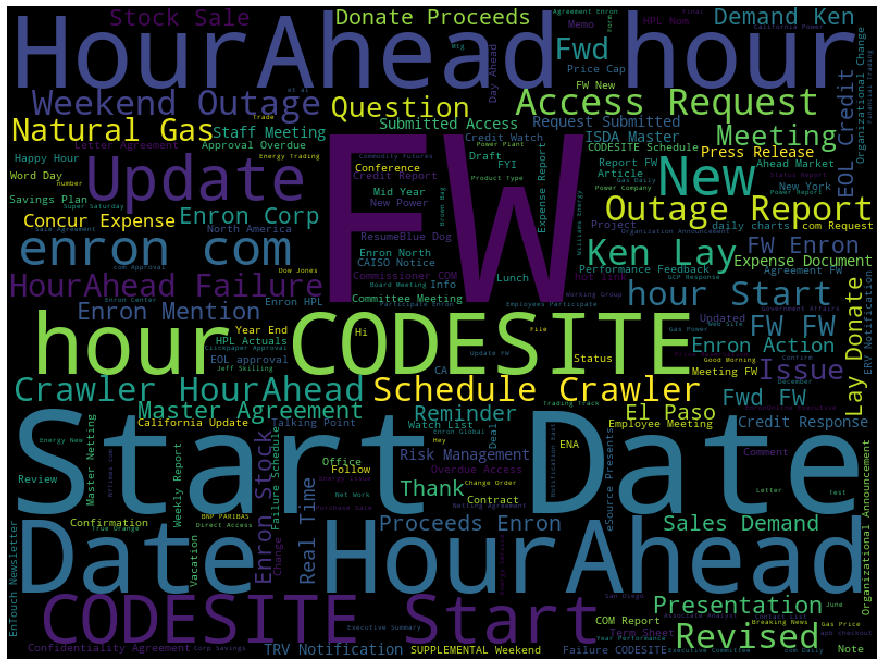

In [26]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
subjects = ' '.join(data['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

(-0.5, 799.5, 599.5, -0.5)

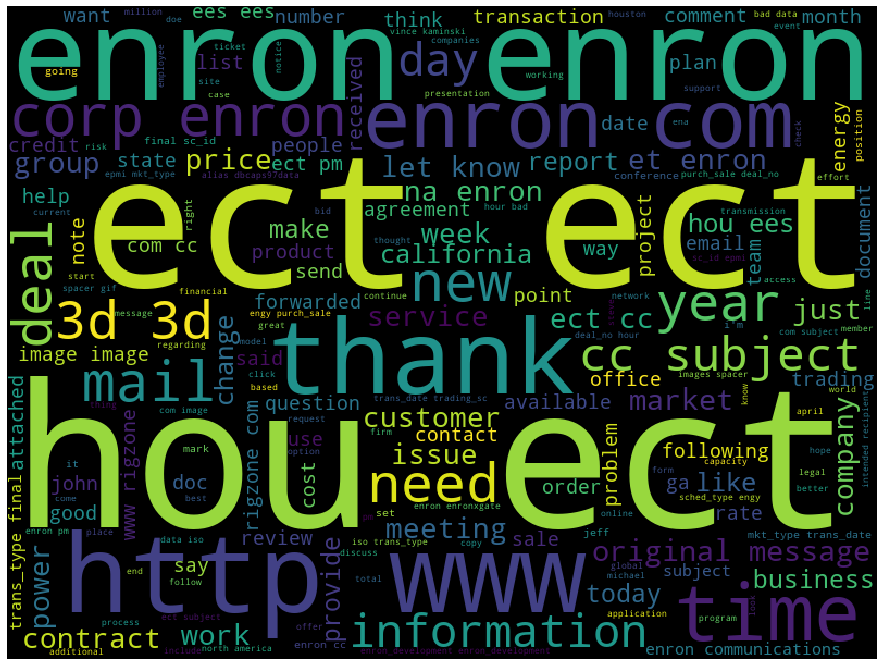

In [27]:
contents = ' '.join(data.sample(1000)['Message-Body'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")

__WORD CLOUDIS USED TO CHECK THE MAXIMUM NO OF WORD USED IN the MESSAGe AND SUBJect__

<h1>DEFINING PARAMETER</h1>

main task is to take message body from the dataset and prepare seperate data frame that only contains messages<br> main task is to make smart compose which predict the output sequence

ACCORDING TO GMAIL SMART COMPOSE RESEaRCH papeR how they predicted the output sequence is by using <br>
Previous e-mail in case the composed e-mail was a response.<br>
• Subject of the e-mail.<br>
• Date and time of the composed e-mail.<br>
– These features help the model suggest appropriate responses like Good morning and Good evening based on the
time of the day and Happy new year and Happy Thanksgiving based on month of the year. They are used as discrete
features for our model.<br>
• Locale of the user composing the e-mail.<br>
– This feature helps the model distinguish between different
spellings like behavior and behaviour between en-US and
en-GB locales.<br>
https://arxiv.org/pdf/1906.00080.pdf

__LETS TRY TO MAKE A MoDEl which contains msg body and try to use teaching forcing technique to generate as many output as possible__<br>

__FOR computational purpose i am taking mail with msg size of 90 because after applying teacher forcing technique my data set size can increase upto 1 million or more__

In [28]:
only_mail= data[(data['Message-Body'].str.len() <90) & ~(data['Subject'].str.contains('Re:'))]

len(only_mail['Message-Body'])

29705

__I am removing number from the msg body because when preprocessing it gives error__

In [0]:
import warnings
warnings.filterwarnings("ignore")
only_mail['Message-Body'] = only_mail['Message-Body'].str.replace('\d+', '')

In [30]:
only_mail['Message-Body'].head()

0                             here is our forecast\n\n 
36    greg,\n\nhappy b-day. email me your phone # an...
43         jeff,\n\n what is up with burnet?\n\nphillip
49    http://www.hearme.com/vc/?chnlownr=pallen@enro...
62    ina,\n\n i scheduled a meeting with jean mrha ...
Name: Message-Body, dtype: object

In [0]:
p=[]
p=only_mail['Message-Body'].values.tolist()

In [0]:
c= p[0:3000]

In [33]:
len(c)

3000

__I am taking only 4000 msgs due to computation power__

In [34]:
c[10:20]

['are we going to inspect tomorrow?',
 'socal position\n\n\n\n\nthis is short, but is it good enough?\n',
 're: window unit check with gary about what kind he wants to install',
 'go ahead and level the floor in #.  ',
 'the file is updated and renamed as gas basis mar .  ',
 'here is the file i showed you.\n\n',
 'here is our forecast\n',
 'i will email you with the insurance info tomorrow.  ',
 'lucy,\n\nthe spreadsheet looks fine to me. \n\nphillip',
 'https://www.rsweb.com//']

__Here is the sample msg we are taking__

__SEQ TO SEQ MODEL FOR MACHINE TRANSLATION__
https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb

Statistical Language Modeling, or Language Modeling and LM for short, is the development of probabilistic models that are able to predict the next word in the sequence given the words that precede it.<br>

Language modeling is the task of assigning a probability to sentences in a language.Besides assigning a probability to each sequence of words, the language models also assigns a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words

In [0]:
#https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb

__TEACHER FORCE TECHNIQUE__

__1) There are sequence prediction models that use the output from the last time step y(t-1) as input for the model at the current time step X(t).__

__2) This type of model is common in language models that output one word at a time and use the output word as input for generating the next word in the sequence.__
https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/

<h2>WORD EMBEDDING</h2>

In [0]:
#it is used to clean puncuation from the string 
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

#preprocess the data
def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>@[\\]^_`{|}~\t\n'
    for line in data:
         pline= clean_special_chars(line.lower(), punct)
         output.append(pline)
    return output  

#this function generate the dataset by adding start and end at the beginning and ending of sentence
def generate_dataset():
    #list of string is send to preprocess
    processed_corpus = preprocess(c)    
    output = []
    for line in processed_corpus:
        sentence = line
        if "." in sentence:
          p1=sentence.split(".")
          #this I do for when one sentence ends with full stop then we have to seperate it.
          for seque in p1:
            for i in range(1, len(seque)):
              l1 = []
              x = 'sos '+ seque[:i+1] + ' eos'
              y = 'sos ' + seque[i+1:] +' eos'
              l1.append(x)
              l1.append(y)
              output.append(l1)
        else:
          for i in range(1, len(sentence)):
            l1 = []
            x = 'sos '+ sentence[:i+1] + ' eos'
            y = 'sos '+ sentence[i+1:] + ' eos'
            l1.append(x)
            l1.append(y)
            output.append(l1)
    teacher_df = pd.DataFrame(output, columns=['input','output'])
    return output,teacher_df

In [0]:
l1,df = generate_dataset()

In [38]:
df.head()

,input,output
0,sos he eos,sos re is our forecast eos
1,sos her eos,sos e is our forecast eos
2,sos here eos,sos is our forecast eos
3,sos here eos,sos is our forecast eos
4,sos here i eos,sos s our forecast eos


__I AM USING SOS AND EOS AT END YOU CAN USE ANYTHING (sos means start of sentence and eos means end of sentence )__

__WE have to train test split at early stage before to prevent Data Imbalancing (80% train 20% test)__

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['input']),np.array(df['output']),test_size=0.1,random_state=0,shuffle=True)

In [40]:
x_tr[3]

'sos the attached lette eos'

In [41]:
y_tr[3]

"sos r is being sent out by bill's office today eos"

__Preparing the tokenizer__

<h2>Input Tokenizer</h2>

In [42]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
#this function returns max length of largest sentence  
def max_length(t):
  return max(len(i) for i in t)

In [0]:
#prepare a tokenizer for Input on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [0]:
#this counts how many words we have in input sentence my input vocab size
tot_cnt = 0
for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1

In [0]:
#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
max_inp_len = max_length(x_tr_seq)
#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_inp_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_inp_len, padding='post')

#size of vocabulary (for padding token)
x_voc   = tot_cnt + 1

__OUTPUT TOKENIZER__

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [0]:
tot_cnt = 0
for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1

In [0]:
#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)
max_out_len = max_length(y_tr_seq)
#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq,  maxlen=max_out_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_out_len, padding='post')

#size of vocabulary ( +1 for padding token)
y_voc   = tot_cnt + 1

__SO TILL NOW WE GET OUR DATA x_tr my input training sentence y_tr my target training sentence__

<h1>TRAINING</h1>

__BEFORE TRAINING lets became familiar with few things__<br>
We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences** = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State** = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**latent dim**  = is my units to pass in LSTM
**AttentionLayer** = Custom attention layer which follows BAHADANU Attention 

**x_vocab** = my input vocaboulary <br>
**y_vocab** = my output vocaboulary


In [0]:
#https://github.com/thushv89/attention_keras/blob/master/layers/attention.py
#this is the manual implementation of AdditiveAttention
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [0]:
#https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim= 300
#https://github.com/thushv89/attention_keras/blob/master/examples/nmt/model.py
# Encoder
encoder_inputs = Input(shape=(max_inp_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output, state_h, state_c = encoder_lstm(enc_emb)
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_output, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
#https://datascience.stackexchange.com/questions/10836/the-difference-between-dense-and-timedistributeddense-of-keras
decoder_dense =  tf.keras.layers.TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [52]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 300)      2807100     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    2658600     input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(), loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [0]:
def fit(model):
  # we use 20% of our data for validation.
  history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                      validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
                      batch_size= 128,
                      epochs= 10)
  return history

In [0]:
def plot_loss(history):
  # Plot the results of the training.
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'], label="Training loss")
  plt.plot(history.history['val_loss'], label="Validation loss")
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [0]:
def plot_acuraccy(history):
  # Plot the results of the training.
  import matplotlib.pyplot as plt
  plt.plot(history.history['sparse_categorical_accuracy'], label="Training accuraccy")
  plt.plot(history.history['val_sparse_categorical_accuracy'], label="Validation accuraccy")
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Accuraccy')
  plt.show()

In [56]:
his= fit(model)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 112277 samples, validate on 12476 samples
Epoch 1/10
112277/112277 [==============================] - 198s 2ms/sample - loss: 1.3633 - sparse_categorical_accuracy: 0.8005 - val_loss: 0.9741 - val_sparse_categorical_accuracy: 0.8334
Epoch 2/10
112277/112277 [==============================] - 189s 2ms/sample - loss: 0.7652 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.5884 - val_sparse_categorical_accuracy: 0.8977
Epoch 3/10
112277/112277 [==============================] - 188s 2ms/sample - loss: 0.5168 - sparse_categorical_accuracy: 0.9082 - val_loss: 0.4267 - val_sparse_categorical_accuracy: 0.9226
Epoch 4/10
112277/112277 [==============================] - 188s 2ms/sample - loss: 0.3836 - sparse_categorical_accuracy: 0.9275 - val_loss: 0.3222 - val_sparse_categorical_accuracy: 0.9377
Epoch 5/10
112277/112277 [==============================] - 188s 2ms/sample - loss: 0.2824 - sp

__GRAPH OF LOSS__

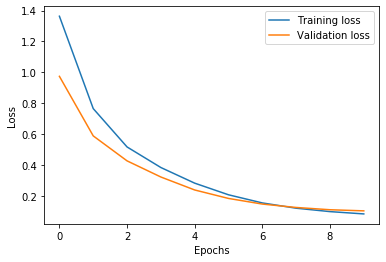

In [175]:
plot_loss(his)

__GRAPH OF ACCURACCY__

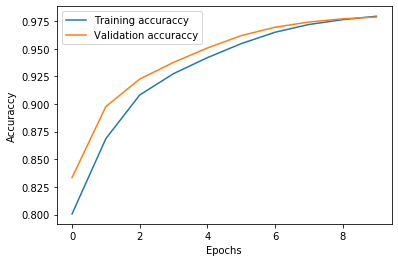

In [173]:
plot_acuraccy(his)

<h1> INTERFACE MODEL FOR PREDICTING SEQUENCE </h1>

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_output, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_inp_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

__SAVING THE ENCODER AND DECODER FOr FUture USe__

In [0]:
encoder_model.save('my_last_model.h5')
encoder_model_file = drive.CreateFile({'title' : 'my_last_model.h5'})                       
encoder_model_file.SetContentFile('my_last_model.h5')                       
encoder_model_file.Upload()

In [0]:
decoder_model.save('my_last_decoder_model.h5')
decoder_model_file = drive.CreateFile({'title' : 'my_last_decoder_model.h5'})                       
decoder_model_file.SetContentFile('my_last_decoder_model.h5')                       
decoder_model_file.Upload()

In [0]:
import pickle
with open('train.pickle', 'wb') as f:
    pickle.dump([x_tr, y_tr ,x_val,y_val,x_tokenizer,y_tokenizer,max_inp_len,max_out_len], f)

In [0]:
uploaded = drive.CreateFile({'title': 'train.pickle'})
uploaded.SetContentFile('train.pickle')
uploaded.Upload()

<end>